#### Libraries importeren

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

#### Set seed

In [2]:
np.random.seed(42)
torch.manual_seed(42)

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


Afbeelding formaat: torch.Size([1, 28, 28])


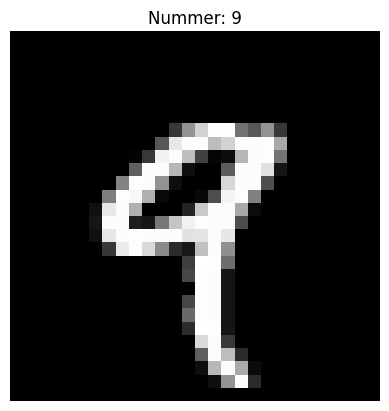

In [12]:
image, label = train_data[4]
print(f"Afbeelding formaat: {image.shape}")

image = image.squeeze().numpy()

plt.axis("off")
plt.title(f"Nummer: {label}")
plt.imshow(image, cmap='gray')
plt.show()

#### Data transformeren

In [17]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)), #Juiste afmetingen invoeren 
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)), #Willekeurige onregelmatigheden 
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3)), #Willekeurig uitwissen van afbeelding
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Architectuur van CNN bouwen

In [18]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(256, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [19]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cuda


#### Model trainen

In [20]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [21]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")

Epoch 1, Loss: 0.9984646260039385
Epoch 2, Loss: 0.5630372339474367
Epoch 3, Loss: 0.4773487985165897
Epoch 4, Loss: 0.4307622679356319
Epoch 5, Loss: 0.4058493053528673
Epoch 6, Loss: 0.3818600037967218
Epoch 7, Loss: 0.3624550426470191
Epoch 8, Loss: 0.3549877362115297
Epoch 9, Loss: 0.33803803833531165
Epoch 10, Loss: 0.3285055808516454


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [22]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

#### Evaluatie van model

In [23]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 9, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 90.24%


#### Nieuwe data inladen en inspecteren

Text(0.5, 1.0, 'Nummer 5')

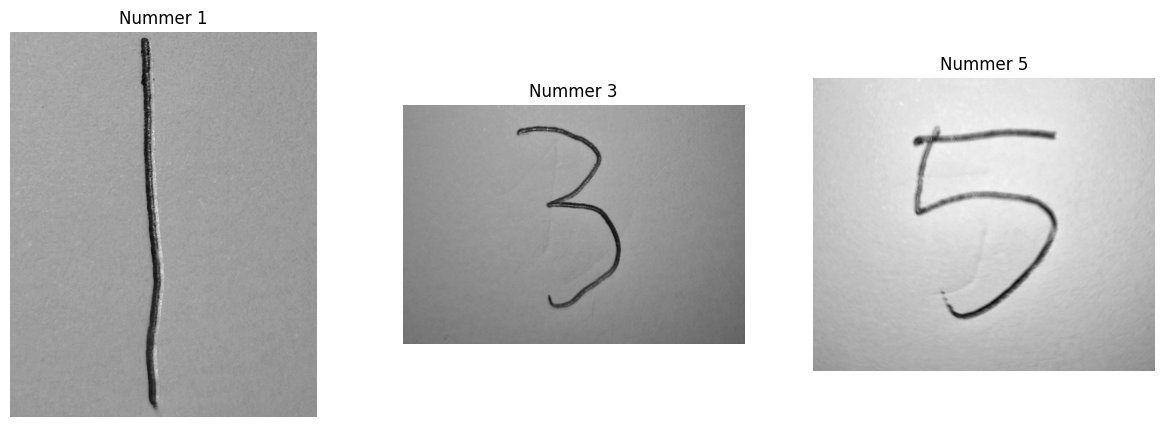

In [24]:
Nummer1 = Image.open("Afbeeldingen/Nummer1.jpg").convert("L")
Nummer3 = Image.open("Afbeeldingen/Nummer3.jpg").convert("L")
Nummer5 = Image.open("Afbeeldingen/Nummer5.jpg").convert("L")

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].imshow(Nummer1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Nummer 1')

axs[1].imshow(Nummer3, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Nummer 3')

axs[2].imshow(Nummer5, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Nummer 5')

#### Nieuwe data verwerken 

In [25]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomInvert(p=1),
    transforms.Normalize((0.1307,), (0.3081))
])

def afbeelding_verwerken(afbeelding):
    afbeelding = transform(afbeelding)
    afbeelding = afbeelding.unsqueeze(0)
    afbeelding = afbeelding.to(component)
    return afbeelding
    
Nummer1 = afbeelding_verwerken(Nummer1)
Nummer3 = afbeelding_verwerken(Nummer3)
Nummer5 = afbeelding_verwerken(Nummer5)

#### Nieuwe data introduceren in CNN

In [ ]:
model.eval()
with torch.no_grad():
    test_output = model(Nummer3)
    zekerheidsgraad = torch.softmax(test_output, dim=1)
    voorspelling = torch.argmax(zekerheidsgraad, 1).item()
    zekerheid = zekerheidsgraad[0][voorspelling].item()
    
    print(f"Het model denkt dat dit cijfer een {voorspelling} is met een zekerheidsgraad van {zekerheid:.4f}!")
    print(test_output)

Het model denkt dat dit cijfer een 8 is met een zekerheidsgraad van 0.3904!
tensor([[-0.7603,  0.1374, -0.1659,  1.0704, -2.8617,  0.4449, -0.2546, -0.9888,
          1.6878, -1.2045]], device='cuda:0')
